In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, InceptionV3
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
# Load CIFAR10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [3]:
# Choose a pre-trained model (e.g., VGG19)
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
# Add custom top layers for CIFAR10
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512),
    layers.LeakyReLU(negative_slope=0.1),  # Leaky ReLU activation
    layers.Dropout(0.5),
    layers.Dense(256),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dropout(0.5),
    layers.Dense(128),
    layers.LeakyReLU(negative_slope=0.1),
    layers.Dense(10, activation='softmax')  # Output for CIFAR10
])

model.summary()

# Freeze base model layers for initial evaluation
for layer in base_model.layers:
    layer.trainable = False

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 1, 1, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,452,554 (78.02 MB)

 Trainable params: 20,452,554 (78.02 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Compile and evaluate without fine-tuning
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
# Train the model
history1 = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 30s 15ms/step - accuracy: 0.3633 - loss: 1.7623 - val_accuracy: 0.5137 - val_loss: 1.3689
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 31s 12ms/step - accuracy: 0.4955 - loss: 1.4220 - val_accuracy: 0.5485 - val_loss: 1.3057
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.5204 - loss: 1.3619 - val_accuracy: 0.5611 - val_loss: 1.2557
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 12ms/step - accuracy: 0.5376 - loss: 1.3159 - val_accuracy: 0.5690 - val_loss: 1.2342
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5513 - loss: 1.2831 - val_accuracy: 0.5679 - val_loss: 1.2390
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.5550 - loss: 1.2674 - val_accuracy: 0.5730 - val_loss: 1.2059
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 39s 12ms/step - accuracy: 0.5649 - loss: 1.2441 - val_accuracy: 0.5835 - val_loss: 1.1941
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.5659 -

In [8]:
print("Evaluating with pre-trained weights:")
model.evaluate(x_test, y_test)

Evaluating with pre-trained weights:
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5844 - loss: 1.1764


[1.1877442598342896, 0.5866000056266785]

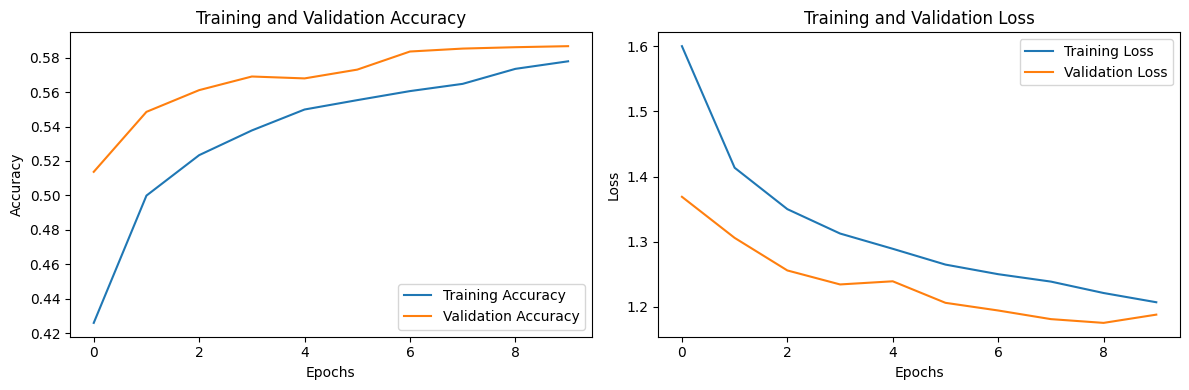

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

## Finetune the model

In [12]:
# Fine-tune the model
for layer in base_model.layers:
    layer.trainable = True  # Unfreeze for fine-tuning

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 109s 62ms/step - accuracy: 0.6366 - loss: 1.0521 - val_accuracy: 0.7477 - val_loss: 0.7481
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 130s 58ms/step - accuracy: 0.7578 - loss: 0.7029 - val_accuracy: 0.7751 - val_loss: 0.6580
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 57ms/step - accuracy: 0.8075 - loss: 0.5681 - val_accuracy: 0.8016 - val_loss: 0.5923
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 91s 58ms/step - accuracy: 0.8415 - loss: 0.4650 - val_accuracy: 0.8152 - val_loss: 0.5508
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 58ms/step - accuracy: 0.8618 - loss: 0.3990 - val_accuracy: 0.8121 - val_loss: 0.5686
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 58ms/step - accuracy: 0.8833 - loss: 0.3328 - val_accuracy: 0.8252 - val_loss: 0.5496
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 142s 58ms/step - accuracy: 0.9082 - loss: 0.2696 - val_accuracy: 0.8296 - val_loss: 0.5614
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 140s 57ms/step - accuracy: 0

In [14]:
# Evaluate the fine-tuned model
print("Evaluating after fine-tuning:")
model.evaluate(x_test, y_test)

Evaluating after fine-tuning:
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.8308 - loss: 0.6398


[0.6350188255310059, 0.8306999802589417]

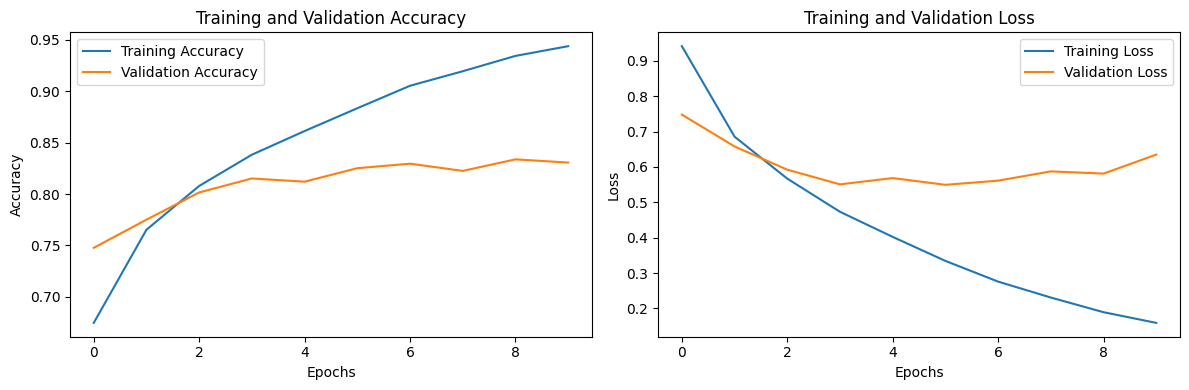

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()